In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [2]:
# Загружу датасет
# Почему-то не сразу загружается

data = pd.read_csv('https://stepik.org/media/attachments/lesson/396012/hw_aa.csv', sep = ';' )

In [4]:
data

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...,...
127013,127014,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127014,127015,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127015,127016,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127016,127017,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


# ---- Мои тесты ----

  0%|          | 0/1000 [00:00<?, ?it/s]

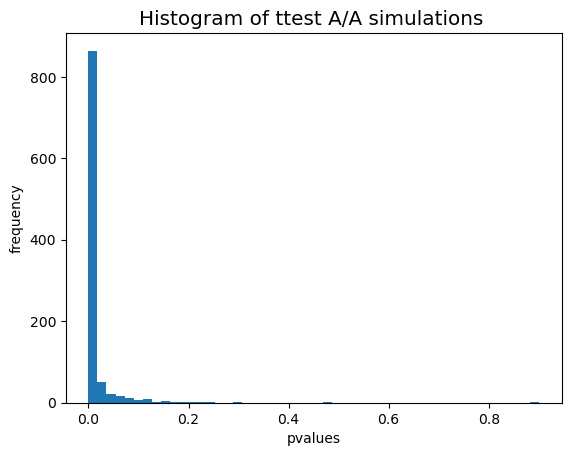

0.933

In [5]:
# АА тест по экспериментальным группам
# действительно проблема сплитования есть, очень много АА тестов аоказывают различия (95,1%)

simulations = 1000
n_s = 1000
res = []


# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = data[data.experimentVariant == 0]['purchase'].sample(n_s, replace = False).values
    s2 = data[data.experimentVariant == 1]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

In [6]:
# Посмотрю какие версии есть и сколько записей для каждой из них в базе данных
data.version.value_counts()

v2.8.0      82835
v2.9.0      23954
v3.8.0.0    11804
v3.7.4.0     8425
Name: version, dtype: int64

In [7]:
# Надо посмотреть как версии представлены в 0-групе и 1-группе
data.groupby(['experimentVariant', 'version']).agg({'version':'count'})
# Версии системы примерно равномерно распределены по 0-группе и 1-группе

version
experimentVariant version          
0                 v2.8.0      41283
                  v2.9.0      11921
                  v3.7.4.0     4204
                  v3.8.0.0     5694
1                 v2.8.0      41552
                  v2.9.0      12033
                  v3.7.4.0     4221
                  v3.8.0.0     6110

In [8]:
# Надо посмотреть как среднее количество покупок представлено в 0-группе и 1-группе 
temp2 = data.groupby(['experimentVariant', 'version'], as_index=False).agg({'purchase':'mean'})
temp2
# А вот с распределением покупок для подгрупп по версии приложения уже есть проблемы

,experimentVariant,version,purchase
0,0,v2.8.0,0.000993
1,0,v2.9.0,0.074658
2,0,v3.7.4.0,0.059943
3,0,v3.8.0.0,0.057604
4,1,v2.8.0,0.045606
5,1,v2.9.0,0.071304
6,1,v3.7.4.0,0.063018
7,1,v3.8.0.0,0.062848


In [9]:
# Переведем в проценты и округлим, что было лучше видно 
# Видно, что в 0-группе для большинства версий приложений меньше покупок, но собенно сильно отличаются % по v2.8.0:
# 0,1% в 0-группе и 4,6% в 1-группе. Для остальных версий разница не столь драматична.
# Тут и без т-теста понятно, что надо удалять данные с этой верисей мобильного приложения и чтот-тест покажет значимые различия
temp2['purchase_percentage'] = round(temp2['purchase']*100, 1)
temp2

,experimentVariant,version,purchase,purchase_percentage
0,0,v2.8.0,0.000993,0.1
1,0,v2.9.0,0.074658,7.5
2,0,v3.7.4.0,0.059943,6.0
3,0,v3.8.0.0,0.057604,5.8
4,1,v2.8.0,0.045606,4.6
5,1,v2.9.0,0.071304,7.1
6,1,v3.7.4.0,0.063018,6.3
7,1,v3.8.0.0,0.062848,6.3


In [10]:
# Видим, в среднем количество покупок для 0-группы примерно 2,4%, а для 1-группы - 5,3%. Неудивительно, что АА-тест показывал 
# такой результат
data.groupby(['experimentVariant'], as_index=False).agg({'purchase':'mean'})

,experimentVariant,purchase
0,0,0.023945
1,1,0.053242


# Давайте удалим версию v2.8.0 и запустим АА-тест заново! 

In [11]:
# Фильтруем данные
data_2 = data.query('version != "v2.8.0"')

In [12]:
# Проверяем себя - да, данные удалены
data_2.version.unique()

array(['v2.9.0', 'v3.7.4.0', 'v3.8.0.0'], dtype=object)

  0%|          | 0/1000 [00:00<?, ?it/s]

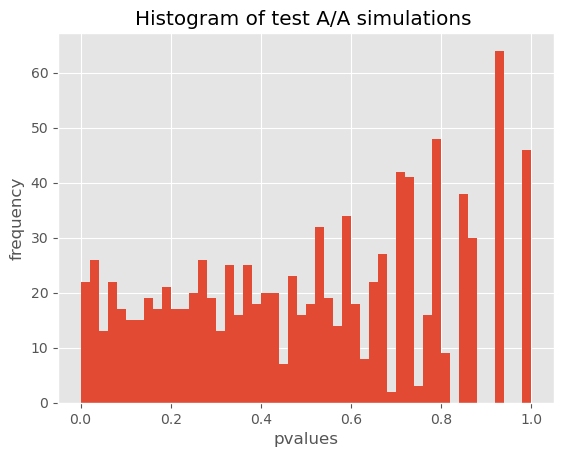

0.057

In [13]:
# АА тест по экспериментальным группам
# Первый тест выдал 0.053 - выше порога в 0.05, хотя и рядом с ним
# Поэтому я провел еще несколько тестов, вот результаты: 0.053, 0.042, 0.44, 0.052, 0.045, 0.042
# В 2 из 6 АА-тестов значение FPR было выше 0.05. Результаты неустойчивы.
# Подозреваю, что результаты т-тестов для других версий будут > 0.05, но надо проверить


simulations = 1000
n_s = 1000
res = []


# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = data_2[data_2.experimentVariant == 0]['purchase'].sample(n_s, replace = False).values
    s2 = data_2[data_2.experimentVariant == 1]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of test A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

In [14]:
# Вывожу еще раз, для проверки, чтобы не ошибиться
# Посмотрю какие версии есть и сколько записей для каждой из них в базе данных
data.groupby(['experimentVariant', 'version']).agg({'version':'count'})

version
experimentVariant version          
0                 v2.8.0      41283
                  v2.9.0      11921
                  v3.7.4.0     4204
                  v3.8.0.0     5694
1                 v2.8.0      41552
                  v2.9.0      12033
                  v3.7.4.0     4221
                  v3.8.0.0     6110

In [15]:
# Ячейка для проверки корректности запроса с разынми версиями
data.query('experimentVariant == 0 and version == "v3.8.0.0"').purchase

47        1
75        1
110       1
121       0
126       0
         ..
126837    0
126847    0
126852    0
126992    0
126993    0
Name: purchase, Length: 5694, dtype: int64

In [16]:
# для начала все-таки проверил версию v2.8.0
stats.ttest_ind(data.query('experimentVariant == 1 and version == "v2.8.0"').purchase, data.query('experimentVariant == 0 and version == "v2.8.0"').purchase, equal_var = False)

Ttest_indResult(statistic=43.09705159855106, pvalue=0.0)

In [17]:
# Теперь v2.9.0
# p-value ожидаемо > 0.05, нулевая гипотеза не отвергается, связи нет

stats.ttest_ind(data.query('experimentVariant == 1 and version == "v2.9.0"').purchase, data.query('experimentVariant == 0 and version == "v2.9.0"').purchase, equal_var = False)

Ttest_indResult(statistic=-0.997860971925487, pvalue=0.31835686930247525)

In [18]:
# Теперь v3.7.4.0
# p-value ожидаемо > 0.05, нулевая гипотеза не отвергается, связи нет
stats.ttest_ind(data.query('experimentVariant == 1 and version == "v3.7.4.0"').purchase, data.query('experimentVariant == 0 and version == "v3.7.4.0"').purchase, equal_var = False)

Ttest_indResult(statistic=0.5875202960070302, pvalue=0.556870078412284)

In [19]:
# Теперь v3.8.0.0
# p-value ожидаемо > 0.05, нулевая гипотеза не отвергается, связи нет
stats.ttest_ind(data.query('experimentVariant == 1 and version == "v3.8.0.0"').purchase, data.query('experimentVariant == 0 and version == "v3.8.0.0"').purchase, equal_var = False)

Ttest_indResult(statistic=1.1973368830477646, pvalue=0.2311993431794882)

# Вывод

Причина поломки - в пользователях с версией приложения v2.8.0 (старая версия?), их удаление дает очень сильное снижение FPR, однако оно не очень устойчиво и выдает значения в районе 0.05, чуть больше и чуть меньше.
Однако это все, что мы можем выяснить, используя эти данные. 
